In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)    

from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
import config

from HySpecLab.utils import HyperSpectralCalibration as calibration
from HySpecLab.utils import median

# VNIR

In [2]:
X = np.load(os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_VNIR/C1_VNIR/processed/C1_VNIR.npy'))
tiny_X = X.reshape((X.shape[0]*X.shape[1],X.shape[2]))

## Band reduction

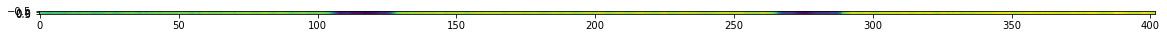

In [5]:
sub_X = X[200:201, 100:-100:2].squeeze() # Una linea reducida
plt.figure(figsize=(20,16))
plt.imshow(sub_X[np.newaxis, :, 10])
plt.show()

In [6]:
from HySpecLab.feature_selection import InterbandRedundancySelector

selector = InterbandRedundancySelector(threshold=10)
selector.fit(sub_X)

InterbandRedundancySelector(threshold=10)

In [7]:
print('Features selected: {}'.format(np.argwhere(selector.mask_ != 0).flatten()))

Features selected: [206 413 619]


In [8]:
n_features = selector.mask_.sum().item()

reduced_tiny_X = selector.transform(tiny_X)
reduced_X = reduced_tiny_X.reshape(X.shape[0],X.shape[1], n_features)

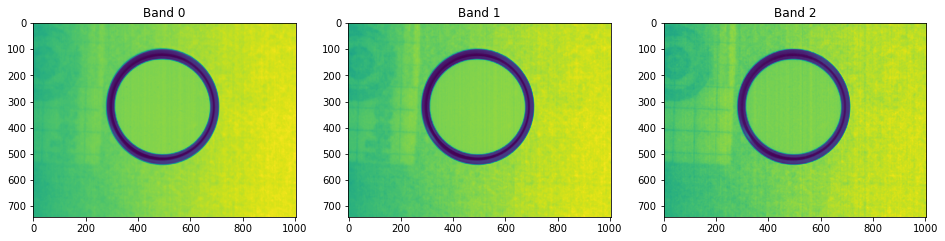

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=n_features, figsize=(16,4))

for i in range(n_features):
    ax[i].imshow(reduced_X[:,:,i])
    ax[i].set_title('Band {}'.format(i))

In [10]:
from HySpecLab.transform import Norm1Transform

transform = Norm1Transform()
sub_X_norm = transform.fit_transform(sub_X)

In [11]:
selector.fit(sub_X_norm)

InterbandRedundancySelector(threshold=10)

In [16]:
n_features = selector.mask_.sum().item()
features_selected = np.argwhere(selector.mask_ != 0).flatten()

reduced_tiny_X_with_norm = selector.transform(tiny_X)
reduced_X_with_norm = reduced_tiny_X_with_norm.reshape(X.shape[0],X.shape[1], n_features)

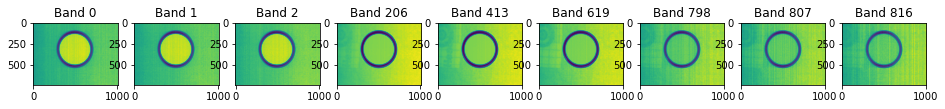

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=n_features, figsize=(16,4))

for i in range(n_features):
    ax[i].imshow(reduced_X_with_norm[:,:,i])
    ax[i].set_title('Band {}'.format(features_selected[i]))

In [26]:
sub_x_zscore = (sub_X - sub_X.mean(axis=0)) / sub_X.std(axis=0)

In [32]:
selector.fit(sub_x_zscore)

InterbandRedundancySelector(threshold=10)

In [33]:
n_features = selector.mask_.sum().item()
features_selected = np.argwhere(selector.mask_ != 0).flatten()

reduced_tiny_X_with_norm = selector.transform(tiny_X)
reduced_X_with_norm = reduced_tiny_X_with_norm.reshape(X.shape[0],X.shape[1], n_features)

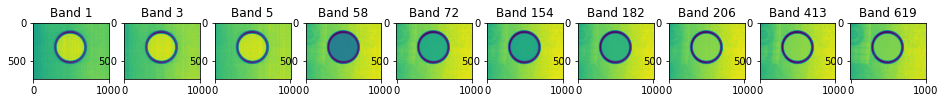

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=n_features, figsize=(16,4))

for i in range(n_features):
    ax[i].imshow(reduced_X_with_norm[:,:,i])
    ax[i].set_title('Band {}'.format(features_selected[i]))

# Preprocessing

In [2]:
import spectral.io.envi as envi

def read_data(capture_id, vnir=True):
    '''
        Return
        ------
            [Capture, White Reference, Black Reference] 
    '''

    spectrum = 'VNIR'
    if not(vnir):
        spectrum = 'NIR'

    if not os.path.exists( os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_{}/{}/'.format(spectrum, capture_id)) ):
        raise ValueError('The capture ID does not exist.')

    ref_path = os.path.join(config.POLYMER_DATASET_DIR, 'Calibration/{}/'.format(spectrum))

    white = envi.open(os.path.join(ref_path, '{}whiteReference.hdr'.format(spectrum)))
    dark = envi.open(os.path.join(ref_path, '{}darkReference.hdr'.format(spectrum)))

    polymer_path = os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_{}/{}/'.format(spectrum, capture_id))
    polymer = envi.open(os.path.join(polymer_path, 'raw.hdr'))

    bands = np.arange(polymer.nbands)

    return polymer.read_bands(bands), white.read_bands(bands), dark.read_bands(bands)

def processing(img, white_ref, dark_ref):
    img = calibration(img, white_ref, dark_ref)
    img = median(img, kernel_size=5)
    return (img / img.max())

    

In [3]:
vnir_samples = os.listdir(os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_VNIR'))
nir_samples = os.listdir(os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_NIR'))

for sample in vnir_samples:
    print('Sample {}'.format(sample))
    img, white, dark = read_data(sample, vnir=True)
    img = processing(img, white, dark)
    break


Sample C1_VNIR


100%|██████████| 826/826 [03:46<00:00,  3.64Features/s]


In [7]:
vnir_path = os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_VNIR')
vnir_samples = os.listdir(vnir_path)

sample = vnir_samples[0]
save_dir = os.path.join(vnir_path, sample, 'processed/{}.npy'.format(sample))
print(save_dir)

/home/abian/Data/Dataset/IUMA/Polymer/Polimero/Sensor_VNIR/C1_VNIR/processed/C1_VNIR.npy


In [4]:
img=None

In [ ]:
img, white, dark = read_data('C1_NIR', vnir=False)
img.shape
dark.shape

In [ ]:
import spectral.io.envi as envi

vnir_ref_path = os.path.join(config.POLYMER_DATASET_DIR, 'Calibration/VNIR/')

vnir_white_data = envi.open(os.path.join(vnir_ref_path, 'VNIRwhiteReference.hdr'))
vnir_dark_data = envi.open(os.path.join(vnir_ref_path, 'VNIRdarkReference.hdr'))

vnir_polymer_path = os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_VNIR/C1_VNIR/')
vnir_polymer = envi.open(os.path.join(vnir_polymer_path, 'raw.hdr'))


img = vnir_polymer.read_bands(np.arange(vnir_polymer.nbands))
dark_ref = vnir_dark_data.read_bands(np.arange(vnir_dark_data.nbands))
white_ref = vnir_white_data.read_bands(np.arange(vnir_white_data.nbands))

c_vnir_img = calibration(img, white_ref, dark_ref)
c_vnir_img = median(c_vnir_img, kernel_size=5)
c_vnir_img = (c_vnir_img / c_vnir_img.max())


In [ ]:
c_vnir_img = None
vnir_white_data = None
vnir_dark_data = None
vnir_polymer = None
img = None

## Read Data and Calibration

In [ ]:
import spectral.io.envi as envi

vnir_ref_path = os.path.join(config.POLYMER_DATASET_DIR, 'Calibration/VNIR/')

vnir_white_data = envi.open(os.path.join(vnir_ref_path, 'VNIRwhiteReference.hdr'))
vnir_dark_data = envi.open(os.path.join(vnir_ref_path, 'VNIRdarkReference.hdr'))

vnir_polymer_path = os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_VNIR/C1_VNIR/')
vnir_polymer = envi.open(os.path.join(vnir_polymer_path, 'raw.hdr'))

# Bands to use
bands = np.linspace(0, vnir_white_data.nbands-1, num=128, dtype=np.uint)

img = vnir_polymer.read_bands(bands)
dark_ref = vnir_dark_data.read_bands(bands)
white_ref = vnir_white_data.read_bands(bands)

vnir_white_data = None
vnir_dark_data = None
vnir_polymer = None

c_vnir_img = calibration(img, white_ref, dark_ref)
# Filter and Normalize
c_vnir_img = median(c_vnir_img, kernel_size=5)
c_vnir_img = (c_vnir_img / c_vnir_img.max())

dark_ref = None
white_ref = None

vnir_w, vnir_h, vnir_c = c_vnir_img.shape 
tiny_vnir_img = c_vnir_img.reshape(vnir_w*vnir_h, vnir_c)

## 1-Norm

In [ ]:
from HySpecLab.transform import Norm1Transform

transform = Norm1Transform()
tiny_vnir_img_norm = transform.fit_transform(tiny_vnir_img)
vnir_img_norm = tiny_vnir_img_norm.reshape(vnir_w, vnir_h, vnir_c)

# Plot signals

* **tiny_vnir_img**
* **tiny_vnir_img_norm**
* **tiny_vnir_img_norm_filtered** 

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

samples_idx = np.arange(0, 1200, 400)

ax[0].set_title('Original')
ax[0].plot(tiny_vnir_img[samples_idx].T)
ax[1].set_title('1-Norm')
ax[1].plot(tiny_vnir_img_norm[samples_idx].T)

plt.show()

In [ ]:
from sklearn.decomposition import IncrementalPCA, PCA

n_components = 5
# pca = IncrementalPCA(n_components=n_components)
pca = PCA(n_components=n_components)
test = pca.fit_transform(tiny_vnir_img.copy())
test = test.reshape(vnir_w, vnir_h, n_components)

test_norm = pca.fit_transform(tiny_vnir_img_norm.copy())
test_norm = test_norm.reshape(vnir_w, vnir_h, n_components)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=n_components, figsize=(16,4))

for i in range(n_components):
    ax[0, i].imshow(test[:,:,i])
    ax[0, i].set_title('Component {}'.format(i))
    ax[0, i].set_xticklabels([])
    ax[0, i].set_yticklabels([])

ax[0, 0].set_ylabel('Original')

for i in range(n_components):
    ax[1, i].imshow(test_norm[:,:,i])
    ax[1, i].set_xticklabels([])
    ax[1, i].set_yticklabels([])

ax[1, 0].set_ylabel('1-Norm')

plt.show()


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

ax[0].set_title('Original')
ax[0].set_xlabel('Commponent 1')
ax[0].set_ylabel('Commponent 0')
ax[0].scatter(test[:,:, 1].flatten()[::50], test[:,:, 0].flatten()[::50])

ax[1].set_title('1-Norm')
ax[1].set_xlabel('Commponent 1')
ax[1].set_ylabel('Commponent 0')
ax[1].scatter(test_norm[:,:, 1].flatten()[::50], test_norm[:,:, 0].flatten()[::50])
plt.show()

In [ ]:
cmp_0 = test_norm[:,:, 0].flatten().reshape(-1,1)
cmp_1 = test_norm[:,:, 1].flatten().reshape(-1,1)

X = np.concatenate([cmp_0, cmp_1], axis=1)

In [ ]:
from sklearn.cluster import KMeans
n_clusters = 4
model = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=n_clusters+1, figsize=(16,4))

result = model.labels_.reshape(vnir_w, vnir_h)

ax[0].imshow(result)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

for i in range(n_clusters):
    mask = np.zeros(result.shape)
    mask[np.where(result==i)] = 1
    ax[i+1].imshow(mask)
    ax[i+1].set_title('Label {}'.format(i))
    ax[i+1].set_xticklabels([])
    ax[i+1].set_yticklabels([])

plt.show()

In [ ]:
from scipy import linalg

selected_data = tiny_vnir_img
C   = np.cov(selected_data.T)
D,V = linalg.eig(C)
print(D)

In [ ]:
plt.imshow(C)
plt.colorbar()

In [ ]:
TinyVecsPCA = np.dot(V.T, selected_data.T)


In [ ]:
TinyVecsPCA.shape

In [ ]:
P1 = TinyVecsPCA[0, :]
PCAIm      = np.reshape(P1, (vnir_w, vnir_h))
plt.imshow(PCAIm)

# Features Selection

In [ ]:
from HySpecLab.feature_selection import InterbandRedundancySelector

selector = InterbandRedundancySelector(threshold=12)
selector.fit(tiny_vnir_img_norm[::25,:])

In [ ]:
print('Features selected: {}'.format(np.argwhere(selector.mask_).flatten()))

In [ ]:
n_features = selector.mask_.sum().item()
tiny_vnir_reduced = selector.transform(tiny_vnir_img).reshape(vnir_w, vnir_h, n_features)
fig, ax = plt.subplots(nrows=1, ncols=n_features, figsize=(16,4))

for i in range(n_features):
    ax[i].imshow(tiny_vnir_reduced[:,:, i])
    # ax[i].set_title('Label {}'.format(i))
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

plt.show()

# NIR

In [ ]:
import spectral.io.envi as envi

nir_ref_path = os.path.join(config.POLYMER_DATASET_DIR, 'Calibration/NIR/')

nir_white_data = envi.open(os.path.join(nir_ref_path, 'NIRwhiteReference.hdr'))
nir_dark_data = envi.open(os.path.join(nir_ref_path, 'NIRdarkReference.hdr'))

nir_polymer_path = os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_NIR/C1_NIR/')
nir_polymer = envi.open(os.path.join(nir_polymer_path, 'raw.hdr'))

bands = np.arange(nir_polymer.nbands)
img = nir_polymer.read_bands(bands)
dark_ref = nir_dark_data.read_bands(bands)
white_ref = nir_white_data.read_bands(bands)

nir_white_data = None
nir_dark_data = None
nir_polymer = None

c_nir_img = calibration(img, white_ref, dark_ref)
# Filter and Normalize
c_nir_img = median(c_nir_img, kernel_size=5)
c_nir_img = (c_nir_img / c_nir_img.max())

dark_ref = None
white_ref = None

nir_w, nir_h, nir_c = c_nir_img.shape 
tiny_nir_img = c_nir_img.reshape(nir_w*nir_h, nir_c)

## 1-Norm

In [ ]:
from HySpecLab.transform import Norm1Transform

transform = Norm1Transform()
tiny_nir_img_norm = transform.fit_transform(tiny_nir_img)
nir_img_norm = tiny_nir_img_norm.reshape(nir_w, nir_h, nir_c)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

samples_idx = np.arange(0, 800, 400)

ax[0].set_title('Original')
ax[0].plot(tiny_nir_img[samples_idx].T)
ax[1].set_title('1-Norm')
ax[1].plot(tiny_nir_img_norm[samples_idx].T)

plt.show()

In [ ]:
from sklearn.decomposition import IncrementalPCA, PCA

n_components = 5
# pca = IncrementalPCA(n_components=n_components)
pca = PCA(n_components=n_components)
test = pca.fit_transform(tiny_nir_img.copy())
test = test.reshape(nir_w, nir_h, n_components)

test_norm = pca.fit_transform(tiny_nir_img_norm.copy())
test_norm = test_norm.reshape(nir_w, nir_h, n_components)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=n_components, figsize=(16,4))

for i in range(n_components):
    ax[0, i].imshow(test[:,:,i])
    ax[0, i].set_title('Component {}'.format(i))
    ax[0, i].set_xticklabels([])
    ax[0, i].set_yticklabels([])

ax[0, 0].set_ylabel('Original')

for i in range(n_components):
    ax[1, i].imshow(test_norm[:,:,i])
    ax[1, i].set_xticklabels([])
    ax[1, i].set_yticklabels([])

ax[1, 0].set_ylabel('1-Norm')

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

ax[0].set_title('Original')
ax[0].set_xlabel('Commponent 1')
ax[0].set_ylabel('Commponent 0')
ax[0].scatter(test[:,:, 1].flatten()[::50], test[:,:, 0].flatten()[::50])

ax[1].set_title('1-Norm')
ax[1].set_xlabel('Commponent 1')
ax[1].set_ylabel('Commponent 0')
ax[1].scatter(test_norm[:,:, 1].flatten()[::50], test_norm[:,:, 0].flatten()[::50])
plt.show()

In [ ]:
cmp_0 = test[:,:, 0].flatten().reshape(-1,1)
cmp_1 = test[:,:, 1].flatten().reshape(-1,1)

X = np.concatenate([cmp_0, cmp_1], axis=1)

In [ ]:
from sklearn.cluster import KMeans
n_clusters = 3
model = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=n_clusters+1, figsize=(16,4))

result = model.labels_.reshape(nir_w, nir_h)

ax[0].imshow(result)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

for i in range(n_clusters):
    mask = np.zeros(result.shape)
    mask[np.where(result==i)] = 1
    ax[i+1].imshow(mask)
    ax[i+1].set_title('Label {}'.format(i))
    ax[i+1].set_xticklabels([])
    ax[i+1].set_yticklabels([])

plt.show()